<a href="https://colab.research.google.com/github/Vincent-ondeng/SAM-for-Geospatial-data/blob/main/Satellite_data_classification_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyrsgis rasterio

In [2]:
import os
from pyrsgis import raster
from pyrsgis.convert import changeDimension
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show

In [3]:
training_multispectral = '/content/Machakos_Town.tif'
training_binary = '/content/Machakos Binary Layer1.tif'
nyeri_town = '/content/data.tif'

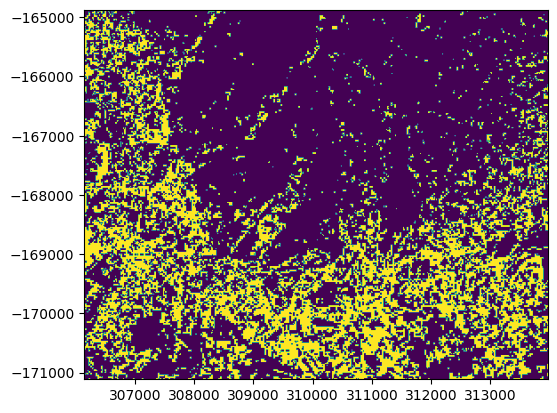

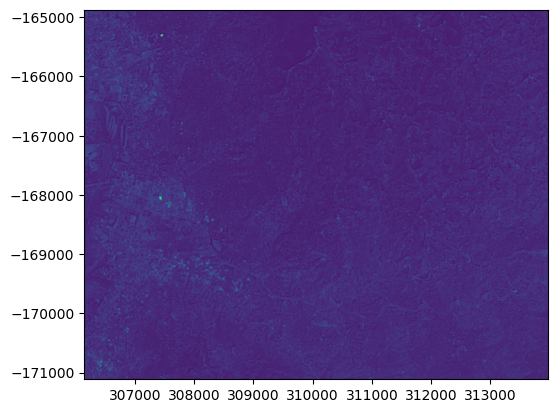

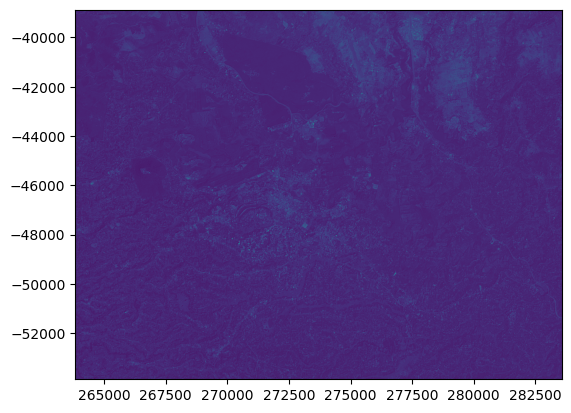

<Axes: >

In [6]:
img = rasterio.open(training_binary)
show(img)

img = rasterio.open(training_multispectral)
show(img)

img = rasterio.open(nyeri_town)
show(img)

In [7]:
# Read the raster as array
ds1, featuresMachakos = raster.read(training_multispectral, bands='all')
ds2, labelMachakosB = raster.read(training_binary, bands ='all')
ds3, featuresNyeri = raster.read(nyeri_town, bands='all')

In [8]:
print(featuresMachakos.shape)
print(labelMachakosB.shape)
print(featuresNyeri.shape)

(7, 416, 522)
(416, 522)
(7, 1000, 1317)


In [9]:
featuresMachakos = changeDimension(featuresMachakos)
labelMachakosB = changeDimension(labelMachakosB)
featuresNyeri = changeDimension(featuresNyeri)
nBands = featuresMachakos.shape[1]
labelMachakosB = (labelMachakosB == 1).astype(int)

print(featuresMachakos.shape)
print(labelMachakosB.shape)
print(featuresNyeri.shape)

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
(217152, 7)
(217152,)
(1317000, 7)


In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(featuresMachakos, labelMachakosB, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(130291, 7)
(130291,)
(86861, 7)
(86861,)


In [11]:
# Normalise the data
xTrain = xTrain / 255.0
xTest = xTest / 255.0
featuresMachakos = featuresMachakos / 255.0

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresMachakos = featuresMachakos.reshape((featuresMachakos.shape[0], 1, featuresMachakos.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, featuresMachakos.shape)

(130291, 1, 7) (86861, 1, 7) (217152, 1, 7)


In [12]:
# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=20)

Epoch 1/20
4072/4072 [==============================] - 17s 3ms/step - loss: 0.7572 - accuracy: 0.7226
Epoch 2/20
4072/4072 [==============================] - 13s 3ms/step - loss: 0.4912 - accuracy: 0.7170
Epoch 3/20
4072/4072 [==============================] - 13s 3ms/step - loss: 0.4844 - accuracy: 0.7172
Epoch 4/20
4072/4072 [==============================] - 14s 3ms/step - loss: 0.4836 - accuracy: 0.7167
Epoch 5/20
4072/4072 [==============================] - 14s 3ms/step - loss: 0.4407 - accuracy: 0.7390
Epoch 6/20
4072/4072 [==============================] - 13s 3ms/step - loss: 0.4039 - accuracy: 0.7780
Epoch 7/20
4072/4072 [==============================] - 13s 3ms/step - loss: 0.3890 - accuracy: 0.7946
Epoch 8/20
4072/4072 [==============================] - 13s 3ms/step - loss: 0.3779 - accuracy: 0.8048
Epoch 9/20
4072/4072 [==============================] - 14s 3ms/step - loss: 0.3653 - accuracy: 0.8155
Epoch 10/20
4072/4072 [==============================] - 13s 3ms/step - l

In [13]:
# Predict for test data
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

2715/2715 [==============================] - 5s 2ms/step
Confusion matrix: for 14 nodes
 [[60814  2719]
 [ 5915 17413]]

P-Score: 0.865, R-Score: 0.746


In [ ]:
#predicted = model.predict(featuresMachakos)
#predicted = predicted[:,1]

#Export raster
#prediction = np.reshape(predicted, (ds.RasterYSize, ds.RasterXSize))
#outFile = 'Nyeri_town.tif'
#raster.export(prediction, ds3, filename=outFile, dtype='float')